## Problem Statement
In this Project, I have worked upon creating content for our customers. Now I didn't have the marketing content data.
Hence I used a dataset consisting of lyrics of Taylor Swift's songs but that's relatable, isn't it? We are going to use the same stuff in automated marketing content creation too. .

The flow of this Analysis will be:
- First I have imported the dataset of lyrics of Taylor Swift's songs and created a corpus consisting of sentences. 

- We then fit the tokenizer on our corpus and store the data related to corpus in tokenizer itself, so now each word has an index starting from 1.

- From there we get input sequences on the basis of numerical arrangement of order of words.

- We made it as a supervised learning problem, labels are predicted using predictors andd built a model consisting of embedding layer for word embeddings, Bidirectional LSTM, LSTM and Dense Layer

- In the Last step, content is predicted using our two functions which are get_content and create_content and all of these steps have been explained below

In [2]:
#importing suitable libraries 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import Regularizer

import tensorflow.keras.utils as ku 
import numpy as np

#### Step 1. Reading our Data

In [27]:
import urllib.request

url = "https://github.com/swap-253/Machine-Learning-and-Data-Science-in-Marketing-Use-Cases/blob/main/Content%20Creation%20Using%20AI/Taylor%20Swift%20Songs.txt"
data = urllib.request.urlopen(url).read().decode("utf-8")

#### Step 2. A basic data preprocessing, elimination of white spaces and alphanumeric characters

In [37]:
import re
data = re.sub(r'[^\w\s]', '', data)

**\r\n depict either end of a sentence or next sentence and we need to eliminate them as a preprocessing step**

In [38]:
# Splitting the string into sentences, while converting whole data into lowercase. 
corpus = data.lower().split("\r\n")

In [39]:
# Now, to make sure no sentence appears twice in our corpus, we use set. Otherwise, it will make the model biased.
corpus = list(set(corpus))
for i in range(len(corpus)):
    sentence = corpus[i]
    sentence = "startsentence " + sentence + " endsentence"
    corpus[i] = sentence

In [40]:
new_corpus = []
for i in range(0, len(corpus), 3):
    if i+1 in range(len(corpus)):
        sentence = corpus[i] + " newsentence " + corpus[i+1]
        new_corpus.append(sentence)
print(new_corpus[1])
print(corpus[3])

startsentence but you come back to what you need endsentence newsentence startsentence i grew up in a pretty house and i had space to run endsentence
startsentence but you come back to what you need endsentence


In [41]:
temp = corpus + new_corpus
corpus1 = []
for i in temp:
    if i not in corpus1:
        corpus1.append(i)

**As we can see from here that corpus1 is the final corpus on whom I am gonna fit my tokenizer**

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus1)
total_words = len(tokenizer.word_index) + 1
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[max(0, i-6):i+1]
        input_sequences.append(n_gram_sequence)
# pad sequences with 0s is the starting if the length of sequence is smaller than the max len
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
#one hot encoding of labels
label = ku.to_categorical(label, num_classes=total_words)

In [50]:
print("Input Sequences")
print(input_sequences)
print("Shape of Input Sequences", input_sequences.shape)

Input Sequences
[[   0    0    0 ...    0    1   13]
 [   0    0    0 ...    1   13  163]
 [   0    0    0 ...   13  163   23]
 ...
 [ 371   18  362 ...   12    6 1029]
 [  18  362  537 ...    6 1029   79]
 [ 362  537   12 ... 1029   79    2]]
Shape of Input Sequences (26176, 7)


**As we can see from above input sequence, so our model is gotta work as follows:-** 

**It will train taking input as 1 and output as 13. Then it will take inputs as 1 and 13 and output as 163. Further it will take inputs as 1,13,163 and output as 23 and so on.**

In [51]:
print("Predictors")
print(predictors)
print("Shape of predictors is", predictors.shape)

Predictors
[[   0    0    0    0    0    1]
 [   0    0    0    0    1   13]
 [   0    0    0    1   13  163]
 ...
 [ 371   18  362  537   12    6]
 [  18  362  537   12    6 1029]
 [ 362  537   12    6 1029   79]]
Shape of predictors is (26176, 6)


In [52]:
print("Label")
print(label)
print("Shape of predictors is", label.shape)

Label
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
Shape of predictors is (26176, 2402)


### Creating Our Sequential Model

In [13]:
#creating sequential Model consisting of word embeddings, Bidirectional LSTM,LSTM and Dense Layers
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))  #(# Embedding Layer)
model.add(Bidirectional(LSTM(150, return_sequences=True)))  #(An LSTM Layer)
model.add(Dropout(0.2))  #(# A dropout layer for regularisation)
model.add(LSTM(100))  #(# Another LSTM Layer)
model.add(Dense(total_words/2, activation='relu'))  #(# A Dense Layer including regularizers)
#(# Last Layer, the shape is equal to total number of words present in our vocabulary)
model.add(Dense(total_words, activation='softmax'))  
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6, 50)             120100    
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 300)            241200    
_________________________________________________________________
dropout (Dropout)            (None, 6, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1201)              121301    
_________________________________________________________________
dense_1 (Dense)              (None, 2402)              2887204   
Total params: 3,530,205
Trainable params: 3,530,205
Non-trainable params: 0
______________________________________________

#### Model Fitting

In [14]:
history = model.fit(predictors, label, epochs= 60, verbose=1)

Epoch 1/60
1433/1433 [==============================] - 22s 9ms/step - loss: 5.2112 - accuracy: 0.1718
Epoch 2/60
1433/1433 [==============================] - 13s 9ms/step - loss: 4.5525 - accuracy: 0.2110
Epoch 3/60
1433/1433 [==============================] - 13s 9ms/step - loss: 4.1303 - accuracy: 0.2405
Epoch 4/60
1433/1433 [==============================] - 13s 9ms/step - loss: 3.7438 - accuracy: 0.2674
Epoch 5/60
1433/1433 [==============================] - 13s 9ms/step - loss: 3.3616 - accuracy: 0.3027
Epoch 6/60
1433/1433 [==============================] - 13s 9ms/step - loss: 2.9815 - accuracy: 0.3492
Epoch 7/60
1433/1433 [==============================] - 12s 9ms/step - loss: 2.6195 - accuracy: 0.4078
Epoch 8/60
1433/1433 [==============================] - 12s 9ms/step - loss: 2.3085 - accuracy: 0.4647
Epoch 9/60
1433/1433 [==============================] - 13s 9ms/step - loss: 2.0390 - accuracy: 0.5211
Epoch 10/60
1433/1433 [==============================] - 13s 9ms/step - l

### Plotting Accuracy/Loss metrics of our Model

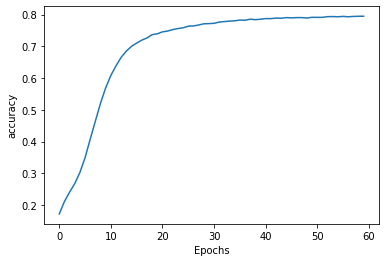

In [15]:
import matplotlib.pyplot as plt
def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
plot_graph(history,'accuracy')

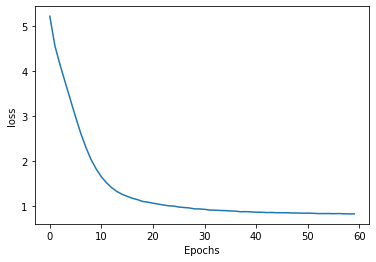

In [16]:
plot_graph(history,'loss')

In [20]:
#Model has been saved since it took a large amount of time to train
model.save('content_model.h5')
from google.colab import files
files.download('content_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Two functions have been defined below:- first is the get_content and second one is the create_content

**Get_Content Function**
<br>
It takes the seed_text which is the beginning from where we want to start the content and then its tokenized and fed into the model after padding which is obvious. I take the predicted word and append it to the seed_text. Now I desire 10 lines of text, so I have to keep track of the number of lines, so if the predicted output is an 'endsentence', we increase end count by 1 until 10 at which we report the final output

In [53]:
def get_content(seed_text):
    ans = True
    end_count = 0
    seed_text = "startsentence " + seed_text 
    while True:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis = -1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == "endsentence":
            end_count += 1
        #adding the content till 10 lines 
        if end_count == 10:
            new_sentence_words = seed_text.split()[1:]
            seed_text = ' '.join(new_sentence_words)
            return(seed_text)
            ans = False
            break
        seed_text += " " + output_word
    # if ans == True:
    #     new_sentence_words = seed_text.split()[1:]
    #     seed_text = ' '.join(new_sentence_words)
    #     return(seed_text)


**Create_Content Function**
<br>
It takes the output from the previous function and then removes words such as 'newsentence' or 'endsentence' and report us a final text

In [56]:
def create_content(text):
    seed_text = get_content(text)
    content = seed_text.split("newsentence")
    for i in range(len(content)):
        sentence = content[i]
        words = sentence.split()
        if "endsentence" in words:
            words.remove("endsentence")
        if "startsentence" in words:
            words.remove("startsentence")
        sentence = ' '.join(words)
        content[i] = sentence
    for sentence in content:
        print(sentence)

In [54]:
create_content("All you need is a reason to move on")

All you need is a reason to move on the road thing think we had
the delicate beginning rush
i hate that stupid old pickup truck
i tried to take the road less traveled by
haha it proudly it proudly
yeah we were dancing oh
and i know its long gone and there was nothing else i could do
do you believe it
but i do
oh im scared to see the ending


In [55]:
create_content("I have to accept this failure and")

I have to accept this failure and always
i imagine you are home
is a ruthless game
couldve loved you all my life if you hadnt left me waiting in the cold
but so does
and the storys got dust on every page
i said you and mean
king of my heart body and soul ooh whoa
with this song for you
is this the end of all the endings
